# Import libraries

In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from dataset import NCFDataset
from recom_ncf import NCFRecommender
from evaluation import Evaluation
from helpers.index_manager import IndexManager

# Loading data

In [2]:
metadata_features = ['log_total_recommendation']

In [3]:
df = pd.read_csv('../data/interaction-clean.csv')[['user_id', 'item_id', 'rating_imp']]
df.head()

,user_id,item_id,rating_imp
0,76561197960432447,10,1
1,76561198071230926,10,1
2,76561198206216352,10,1
3,76561198110801124,10,1
4,76561199813732773,10,1


In [4]:
df_metadata = pd.read_csv('../data/metadata-features-extracted.csv')
df_metadata.head()

,name,item_id,supported_languages,developers,publishers,categories,genres,total_recommendations,price,released_date,...,released_year,released_decade,released_month,released_day_of_week,released_quarter,age,age_category,mm_age,z_age,log_age
0,Clash of Warlords,1430720,"['Simplified Chinese', 'Traditional Chinese']",['XINLINE GAMES'],['XINLINE GAMES'],"['Single-player', 'In-App Purchases', 'Family ...",['Strategy'],0,699.0,2021-02-07,...,2021,2020,2,6,1,3.0,recent,0.111111,-0.167810,1.098612e+00
1,Mine Crazy: The Korean Grinder,1430740,['English'],['Dano Sato'],['RealMono Inc.'],"['Single-player', 'Family Sharing']","['Casual', 'Indie', 'RPG', 'Simulation']",0,199.0,2020-10-08,...,2020,2020,10,3,4,4.0,established,0.148148,0.154011,1.386294e+00
2,Fade,1430100,['English'],['Azimyth Studios'],['Azimyth Studios'],"['Single-player', 'Family Sharing']","['Indie', 'RPG']",0,199.0,2020-10-29,...,2020,2020,10,3,4,4.0,established,0.148148,0.154011,1.386294e+00
3,Clash: Artifacts of Chaos,1430680,"['English', 'French', 'Italian', 'German', 'Sp...",['ACE Team'],['Nacon'],"['Single-player', 'Steam Achievements', 'Steam...","['Action', 'Adventure', 'Indie']",759,2999.0,2023-03-09,...,2023,2020,3,3,1,1.0,new_release,0.037037,-0.811450,1.000000e-10
4,Astatos,1430970,"['English', 'Simplified Chinese', 'Traditional...",['Studio Klondike Australia'],['Studio Klondike'],"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Adventure', 'Indie', 'Strategy', 'Early Acce...",243,1499.0,2021-12-16,...,2021,2020,12,3,4,3.0,recent,0.111111,-0.167810,1.098612e+00


# Encoding categorical metadata features

In [5]:
import ast
df_metadata['publishers'] = df_metadata['publishers'].apply(ast.literal_eval)
df_metadata['developers'] = df_metadata['developers'].apply(ast.literal_eval)
df_metadata['lang_encoded'] = df_metadata['lang_encoded'].apply(ast.literal_eval)
df_metadata['gen_encoded'] = df_metadata['gen_encoded'].apply(ast.literal_eval)
df_metadata['cat_encoded'] = df_metadata['cat_encoded'].apply(ast.literal_eval)

In [6]:
pop_pub = df_metadata.explode(column='publishers').groupby(by='publishers')['total_recommendations'].sum().reset_index().sort_values(by='total_recommendations', ascending=False)
pop_dev = df_metadata.explode(column='developers').groupby(by='developers')['total_recommendations'].sum().reset_index().sort_values(by='total_recommendations', ascending=False)
pop_pub = pop_pub[:256]['publishers'].unique()
pop_dev = pop_dev[:256]['developers'].unique()

In [7]:
import hashlib

def encode_high_cardinality(values, top_values, num_buckets=256):
    encoding = [0] * (len(top_values) + num_buckets)

    value_to_idx = {val: idx for idx, val in enumerate(top_values)}

    for val in values:
        if val in top_values:
            encoding[value_to_idx[val]] = 1
        else:
            hash_value = int(hashlib.md5(str(val).encode()).hexdigest(), 16)
            bucket = hash_value % num_buckets
            encoding[len(top_values) + bucket] = 1

    return encoding

encode_high_cardinality(['a', 'c', 'e'], ['a'], num_buckets=2)

[1, 1, 1]

In [8]:
df_metadata['publishers'] = df_metadata['publishers'].apply(lambda x: encode_high_cardinality(x, pop_pub))
df_metadata['developers'] = df_metadata['developers'].apply(lambda x: encode_high_cardinality(x, pop_dev))
df_metadata.head()

,name,item_id,supported_languages,developers,publishers,categories,genres,total_recommendations,price,released_date,...,released_year,released_decade,released_month,released_day_of_week,released_quarter,age,age_category,mm_age,z_age,log_age
0,Clash of Warlords,1430720,"['Simplified Chinese', 'Traditional Chinese']","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['Single-player', 'In-App Purchases', 'Family ...",['Strategy'],0,699.0,2021-02-07,...,2021,2020,2,6,1,3.0,recent,0.111111,-0.167810,1.098612e+00
1,Mine Crazy: The Korean Grinder,1430740,['English'],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['Single-player', 'Family Sharing']","['Casual', 'Indie', 'RPG', 'Simulation']",0,199.0,2020-10-08,...,2020,2020,10,3,4,4.0,established,0.148148,0.154011,1.386294e+00
2,Fade,1430100,['English'],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['Single-player', 'Family Sharing']","['Indie', 'RPG']",0,199.0,2020-10-29,...,2020,2020,10,3,4,4.0,established,0.148148,0.154011,1.386294e+00
3,Clash: Artifacts of Chaos,1430680,"['English', 'French', 'Italian', 'German', 'Sp...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['Single-player', 'Steam Achievements', 'Steam...","['Action', 'Adventure', 'Indie']",759,2999.0,2023-03-09,...,2023,2020,3,3,1,1.0,new_release,0.037037,-0.811450,1.000000e-10
4,Astatos,1430970,"['English', 'Simplified Chinese', 'Traditional...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['Single-player', 'Multi-player', 'PvP', 'Onli...","['Adventure', 'Indie', 'Strategy', 'Early Acce...",243,1499.0,2021-12-16,...,2021,2020,12,3,4,3.0,recent,0.111111,-0.167810,1.098612e+00


# Indexing data

In [9]:
index_manager = IndexManager()
index_manager.fit(df_interaction=df)
index_manager.transform_interactions(df, inplace=True)
index_manager.transform_metadata(df_metadata, inplace=True)
df.head()

Indexed 836887 users and 69001 items
User index range: 0-836886
Item index range: 0-69000


,user_id,item_id,rating_imp
0,0,0,1
1,1,0,1
2,2,0,1
3,3,0,1
4,4,0,1


# Creating datasets

In [10]:
df_train_val, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=(0.1/0.9), random_state=42)

train_dataset = NCFDataset(df_train, df_metadata=df_metadata, metadata_features=metadata_features)
val_dataset = NCFDataset(df_val, df_metadata=df_metadata, metadata_features=metadata_features)

train_dataloader = DataLoader(train_dataset, batch_size=16384, num_workers=4, persistent_workers=True, prefetch_factor=2, pin_memory=True, shuffle=True)
eval_dataloader = DataLoader(val_dataset, batch_size=16384, num_workers=4, persistent_workers=True, prefetch_factor=2, pin_memory=True, shuffle=False)

Items in interactions: 63915
Items in metadata: 91284
Items in interactions with metadata: 63348
Items in interactions WITHOUT metadata: 567
Items in interactions: 26190
Items in metadata: 91284
Items in interactions with metadata: 25979
Items in interactions WITHOUT metadata: 211


# Training model

In [11]:
params = {'factors': 8, 'mlp_user_item_dim': 64, 'learning_rate': 0.001, 'epochs': 10, 'optimizer': 'adam', 'dropout': 0.0, 'weight_decay': 1e-05, 'loss_fn': 'bce'}

unique_users = index_manager.get_indexed_users()
unique_items = index_manager.get_indexed_items()

metadata_feature_dims = train_dataset.get_feature_dims()

model = NCFRecommender(unique_users, unique_items, mlp_metadata_embedding_dims=[8]*1, mlp_metadata_feature_dims=metadata_feature_dims, **params)
model.fit(train_dataloader, eval_dataloader)

Epoch 1/10
Train loss: 0.548283, Validation loss: 0.480425
Epoch 2/10
Train loss: 0.474611, Validation loss: 0.472689
Epoch 3/10
Train loss: 0.469136, Validation loss: 0.468057
Epoch 4/10
Train loss: 0.464920, Validation loss: 0.463839
Epoch 5/10
Train loss: 0.460525, Validation loss: 0.459932
Epoch 6/10
Train loss: 0.456594, Validation loss: 0.455936
Epoch 7/10
Train loss: 0.451977, Validation loss: 0.451899
Epoch 8/10
Train loss: 0.447331, Validation loss: 0.448530
Epoch 9/10
Train loss: 0.442848, Validation loss: 0.445436
Epoch 10/10
Train loss: 0.438837, Validation loss: 0.442472
Training completed!


# Evaluating model

In [12]:
evaluator = Evaluation(recommender=model, test_data=df_test, df_metadata=df_metadata, metadata_features=metadata_features)
metrics = evaluator.evaluate()

Starting evaluation preparation...
Creating ground truth sets...
Ground truth created for 105036 users with an average of 1.1 items each
Ground truth creation completed in 2.11 seconds
Analyzing metadata features...
Analyzed 1 metadata features
Metadata analysis completed in 0.04 seconds
Generating predictions for 105036 users...
Processing predictions for 105036 users and 91889 items
Precomputing metadata features...
Metadata precomputation completed in 0.38 seconds
Processing user batch 1/206 (512 users)
Processing user batch 2/206 (512 users)
Processing user batch 3/206 (512 users)
Processing user batch 4/206 (512 users)
Processing user batch 5/206 (512 users)
Processing user batch 6/206 (512 users)
Processing user batch 7/206 (512 users)
Processing user batch 8/206 (512 users)
Processing user batch 9/206 (512 users)
Processing user batch 10/206 (512 users)
Processing user batch 11/206 (512 users)
Processing user batch 12/206 (512 users)
Processing user batch 13/206 (512 users)
Proc

In [13]:
metrics

{'Hit Ratio@10': 3.808218134734758e-05,
 'NDCG@10': 7.901945951742509e-06,
 'Recall@10': 1.734099329209577e-05}

# Find appropriate metadata features

In [19]:
metadata_features = ['log_total_recommendation', 'cat_encoded', 'gen_encoded', 'publishers']

In [25]:
from itertools import combinations
feature_combinations = []
for i in range(1, len(metadata_features)+1):
    feature_combinations.extend(combinations(metadata_features, i))
feature_combinations = [list(combination) for combination in feature_combinations]
feature_combinations

[['log_total_recommendation'],
 ['cat_encoded'],
 ['gen_encoded'],
 ['publishers'],
 ['log_total_recommendation', 'cat_encoded'],
 ['log_total_recommendation', 'gen_encoded'],
 ['log_total_recommendation', 'publishers'],
 ['cat_encoded', 'gen_encoded'],
 ['cat_encoded', 'publishers'],
 ['gen_encoded', 'publishers'],
 ['log_total_recommendation', 'cat_encoded', 'gen_encoded'],
 ['log_total_recommendation', 'cat_encoded', 'publishers'],
 ['log_total_recommendation', 'gen_encoded', 'publishers'],
 ['cat_encoded', 'gen_encoded', 'publishers'],
 ['log_total_recommendation', 'cat_encoded', 'gen_encoded', 'publishers']]

In [26]:
metrics = []
for feature_combination in feature_combinations:
    df_train_val, df_test = train_test_split(df, test_size=0.1, random_state=42)
    df_train, df_val = train_test_split(df_train_val, test_size=(0.1/0.9), random_state=42)

    train_dataset = NCFDataset(df_train, df_metadata=df_metadata, metadata_features=feature_combination)
    val_dataset = NCFDataset(df_val, df_metadata=df_metadata, metadata_features=feature_combination)

    train_dataloader = DataLoader(train_dataset, batch_size=16384, num_workers=4, persistent_workers=True, prefetch_factor=2, pin_memory=True, shuffle=True)
    eval_dataloader = DataLoader(val_dataset, batch_size=16384, num_workers=4, persistent_workers=True, prefetch_factor=2, pin_memory=True, shuffle=False)

    params = {'factors': 8, 'mlp_user_item_dim': 64, 'learning_rate': 0.001, 'epochs': 10, 'optimizer': 'adam', 'dropout': 0.0, 'weight_decay': 0.0, 'loss_fn': 'bce'}

    unique_users = df["user_idx"].unique()
    unique_items = np.union1d(df["item_idx"].unique(), df_metadata['item_idx'].unique())

    metadata_feature_dims = train_dataset.get_feature_dims()

    model = NCFRecommender(unique_users, unique_items, mlp_metadata_embedding_dims=[8]*len(feature_combination), mlp_metadata_feature_dims=metadata_feature_dims, **params)
    model.fit(train_dataloader, eval_dataloader)

    evaluator = Evaluation(recommender=model, test_data=df_test, df_metadata=df_metadata, metadata_features=feature_combination)
    result = {'metrics': evaluator.evaluate(), 'feature_combination': feature_combination}
    metrics.append(result)

Epoch 1/10
Train loss: 0.548995, Validation loss: 0.480906
Epoch 2/10
Train loss: 0.471570, Validation loss: 0.466442
Epoch 3/10
Train loss: 0.454988, Validation loss: 0.452576
Epoch 4/10
Train loss: 0.435858, Validation loss: 0.443662
Epoch 5/10
Train loss: 0.415981, Validation loss: 0.440077
Epoch 6/10
Train loss: 0.395083, Validation loss: 0.441261
Epoch 7/10
Train loss: 0.373322, Validation loss: 0.448952
Epoch 8/10
Train loss: 0.350801, Validation loss: 0.459018
Epoch 9/10
Train loss: 0.327411, Validation loss: 0.474945
Epoch 10/10
Train loss: 0.303881, Validation loss: 0.493429
Early stopping triggered after 10 epochs
Training completed!
Starting evaluation preparation...
Creating ground truth sets...
Ground truth created for 105036 users with an average of 1.1 items each
Ground truth creation completed in 1.56 seconds
Analyzing metadata features...
Analyzed 1 metadata features
Metadata analysis completed in 0.03 seconds
Generating predictions for 105036 users...
Processing predi

In [27]:
metrics

[{'metrics': {'Hit Ratio@10': 0.0005617121748733768,
   'NDCG@10': 0.00025436308871391226,
   'Recall@10': 0.0005195497598102419},
  'feature_combination': ['log_total_recommendation']},
 {'metrics': {'Hit Ratio@10': 0.00037130126813663886,
   'NDCG@10': 0.00014540907631740687,
   'Recall@10': 0.0003427396321261282},
  'feature_combination': ['cat_encoded']},
 {'metrics': {'Hit Ratio@10': 0.0002856163601051068,
   'NDCG@10': 0.00010427196469591243,
   'Recall@10': 0.0002672553083840642},
  'feature_combination': ['gen_encoded']},
 {'metrics': {'Hit Ratio@10': 0.0005236299935260292,
   'NDCG@10': 0.000188542205091124,
   'Recall@10': 0.0004942749787374488},
  'feature_combination': ['publishers']},
 {'metrics': {'Hit Ratio@10': 0.000533150538862866,
   'NDCG@10': 0.00023727766310045393,
   'Recall@10': 0.0005101425542988435},
  'feature_combination': ['log_total_recommendation', 'cat_encoded']},
 {'metrics': {'Hit Ratio@10': 0.00044746563083133403,
   'NDCG@10': 0.0002020085082508057,
 

In [28]:
 hit_ratio = [metrics[feature]['Hit Ratio@10'] for feature in metadata_features]
 ndcg = [metrics[feature]['NDCG@10'] for feature in metadata_features]
 recall = [metrics[feature]['Recall@10'] for feature in metadata_features]

TypeError: list indices must be integers or slices, not str

In [13]:
df_metrics = pd.DataFrame({'metadata_feature': metadata_features, 'hit_ratio': hit_ratio, 'ndcg': ndcg, 'recall': recall})
df_metrics

,metadata_feature,hit_ratio,ndcg,recall
0,mm_total_recommendation,0.000228,0.000098,0.000214
1,z_total_recommendation,0.000257,0.000149,0.000257
2,log_total_recommendation,0.001504,0.000639,0.001454
3,mm_price,0.000362,0.000134,0.000322
4,z_price,0.000152,0.000046,0.000143
5,log_price,0.000381,0.000148,0.000363
6,lang_encoded,0.000200,0.000105,0.000191
7,cat_encoded,0.000447,0.000203,0.000420
8,gen_encoded,0.000476,0.000207,0.000462
9,developers,0.000228,0.000150,0.000211


In [14]:
df_metrics.to_csv('performance/metadata-feature-combination-metrics.csv', index=False)

# Tuning model

In [5]:
from tuner import NCFTuner

df_train_val, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=(0.1/0.9), random_state=42)

unique_users = df["user_idx"].unique()
unique_items = np.union1d(df["item_idx"].unique(), df_metadata['item_idx'].unique()) 

tuner = NCFTuner(
    train_data=df_train,
    val_data=df_val,
    test_data=df_test,
    metadata=df_metadata,
    unique_users=unique_users,
    unique_items=unique_items,
    time_features=['z_timestamp'],
    metadata_features=metadata_features
)

In [6]:
results, file_path = tuner.perform_random_search(num_trials=2)

Running experiment with params: {'factors': 32, 'mlp_user_item_dim': 128, 'mlp_time_dim': 8, 'mlp_metadata_embedding_dims': [8, 8, 8], 'learning_rate': 0.001, 'epochs': 1, 'optimizer': 'sgd', 'dropout': 0.0, 'weight_decay': 1e-05, 'loss_fn': 'mse', 'time_features': 'z_timestamp'}
Epoch 1/1
Train loss: 0.694980, Validation loss: 0.691425
Training completed!
Starting evaluation preparation...
Creating ground truth sets for 105036 users...
Getting most recent timestamps for each user...
Generating predictions...
Total GPU memory: 8.00 GB
Target memory usage: 85%-95% (6.80-7.60 GB)
Processing user batch 1/103 (1024 users)
GPU Memory: Reserved=6.15GB (77.0%), Allocated=1.48GB, Item batch size: 1024
🔼 Low memory usage (77.0%)! Increased item batch size: 1024 → 1331
GPU Memory: Reserved=10.26GB (128.3%), Allocated=1.48GB, Item batch size: 1331
⚠️ High memory usage (128.3%)! Reduced item batch size: 1331 → 665
GPU Memory: Reserved=4.51GB (56.4%), Allocated=1.48GB, Item batch size: 665
🔼 Low me

In [8]:
best_params = tuner.analyze_results(results_file=file_path)
print("Best parameters:", best_params)

Best parameters: {'Hit Ratio@10': {'params': {'factors': 32, 'mlp_user_item_dim': 128, 'mlp_time_dim': 8, 'mlp_metadata_embedding_dims': [8, 8, 8], 'learning_rate': 0.001, 'epochs': 1, 'optimizer': 'sgd', 'dropout': 0.0, 'weight_decay': 1e-05, 'loss_fn': 'mse', 'time_features': 'z_timestamp'}, 'value': 0.00012376708937887962}, 'NDCG@10': {'params': {'factors': 32, 'mlp_user_item_dim': 128, 'mlp_time_dim': 8, 'mlp_metadata_embedding_dims': [8, 8, 8], 'learning_rate': 0.001, 'epochs': 1, 'optimizer': 'sgd', 'dropout': 0.0, 'weight_decay': 1e-05, 'loss_fn': 'mse', 'time_features': 'z_timestamp'}, 'value': 5.957071422377648e-05}, 'Recall@10': {'params': {'factors': 32, 'mlp_user_item_dim': 128, 'mlp_time_dim': 8, 'mlp_metadata_embedding_dims': [8, 8, 8], 'learning_rate': 0.001, 'epochs': 1, 'optimizer': 'sgd', 'dropout': 0.0, 'weight_decay': 1e-05, 'loss_fn': 'mse', 'time_features': 'z_timestamp'}, 'value': 0.00011424654404204273}}


# Analyzing results

TypeError: unhashable type: 'list'

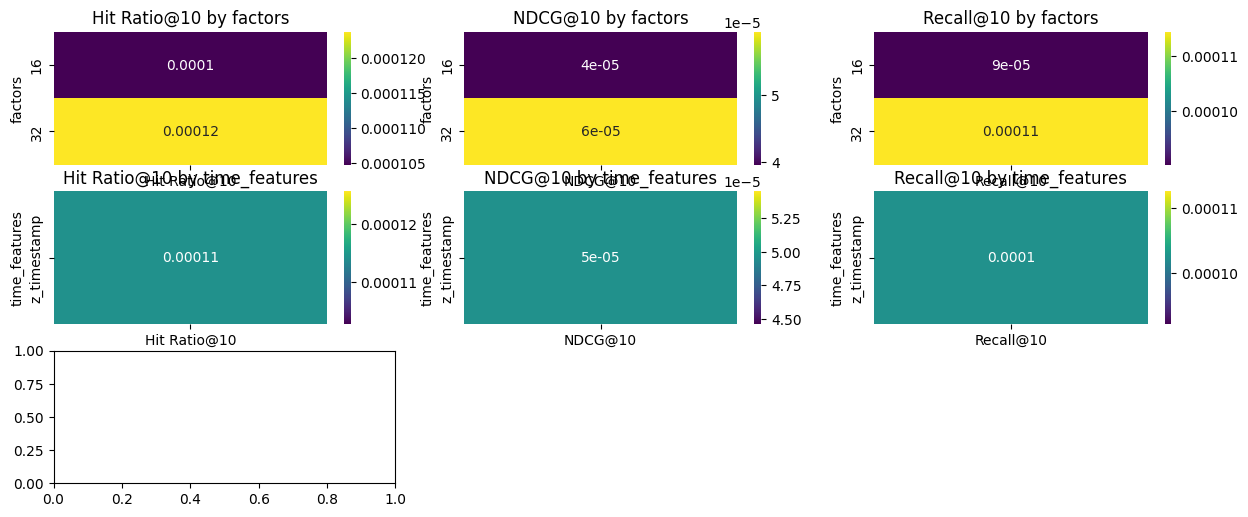

In [9]:
df_result = tuner.plot_results(results_file=file_path)

In [10]:
df_result

NameError: name 'df_result' is not defined

In [ ]:
params = {'factors': 8, 'layers': [128, 64, 32, 16], 'time_factors': 8, 'learning_rate': 0.001, 'epochs': 10, 'optimizer': 'adam', 'dropout': 0.0, 'weight_decay': 1e-05, 'loss_fn': 'bce'}

In [ ]:
time_feature = 'z_timestamp'

df_time = df[required_features + [time_feature]]

df_train_val, df_test = train_test_split(df_time, test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=(0.1/0.9), random_state=42)

train_dataset = NCFDataset(df_train, time_feature=time_feature)
val_dataset = NCFDataset(df_val, time_feature=time_feature)

train_dataloader = DataLoader(train_dataset, batch_size=16384, num_workers=4, persistent_workers=True, prefetch_factor=2, pin_memory=True, shuffle=True)
eval_dataloader = DataLoader(val_dataset, batch_size=16384, num_workers=4, persistent_workers=True, prefetch_factor=2, pin_memory=True, shuffle=False)

unique_users = df["user_idx"].unique()
unique_items = df["item_idx"].unique()

In [ ]:
model = NCFRecommender(unique_users, unique_items, **params)
model.fit(train_dataloader, eval_dataloader)

evaluator = Evaluation(recommender=model, test_data=df_test, time_feature=time_feature)
metrics = evaluator.evaluate()

In [ ]:
metrics

# Interpretting predictions

In [ ]:
df_interaction_count = df.groupby('user_idx')[['item_idx']].nunique().sort_values('item_idx', ascending=False)

In [ ]:
df_interaction_count[df_interaction_count['item_idx'] == 10]

In [ ]:
user_idx = 141666

In [ ]:
df[df['user_idx'] == user_idx]

In [ ]:
latest_timestamp = df_time[df_time['user_idx'] == user_idx]['z_timestamp'].max()

In [ ]:
predictions = model.batch_predict_for_users([user_idx], [latest_timestamp])

In [ ]:
predictions

In [ ]:
df[df['item_idx'].isin(predictions[user_idx])]['item_id'].unique()

In [ ]:
df[df['user_idx'] == user_idx]['item_id'].values